## 0. Setup

In [36]:
setup = """
import torch
import torchvision
import torchvision.transforms as T
from EIANN import Network
import EIANN.utils as ut

device = 'cpu'

# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)
# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))

MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))

# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10000], shuffle=True, generator=data_generator)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

network_seed = 42

# Create network
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')
# network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml')
# network_config = ut.read_from_yaml('../config/MNIST/EIANN_2_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, device=device, **training_kwargs)

# compiled_network = torch.compile(bp_network)
# compiled_network = torch.compile(bp_network, mode="reduce-overhead")
compiled_network = torch.compile(bp_network, mode="max-autotune")

# torch._dynamo.config.suppress_errors = True


def forward_func(network, dataloader):
    for idx, data, target in dataloader:
        # data.squeeze(0).to(device)
        # bp_network(data)
        compiled_network(data)
"""


import timeit

execution_time = timeit.timeit(stmt="forward_func(bp_network, train_sub_dataloader)",
                               setup=setup,
                               number=10)/10
print(f"Avg. execution time: {execution_time} seconds")

# 1-hidden backprop
# Avg. execution time: 2.1079129416599973 seconds

# Avg. execution time: 3.166553417080004 seconds # default
# Avg. execution time: 3.2680223416700027 seconds # reduce-overhead
# Avg. execution time: 3.2423437358299996 seconds # max-autotune

# 1-hidden Dales law
# Avg. execution time: 24.079147207920006 seconds

# Avg. execution time: 36.5288757792001 seconds # default
# Avg. execution time: 35.286221412499984 seconds # reduce-overhead
# Avg. execution time: 33.90144020000007 seconds # max-autotune

Avg. execution time: 43.981780145799895 seconds


In [39]:
setup = """
import torch
import torchvision
import torchvision.transforms as T
from EIANN import Network
import EIANN.utils as ut

device = 'cpu'

# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)
# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))

MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))

# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10000], shuffle=True, generator=data_generator)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

network_seed = 42

# Create network
# network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml')
# network_config = ut.read_from_yaml('../config/MNIST/EIANN_2_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, device=device, **training_kwargs)

def forward_func(network, dataloader):
    for idx, data, target in dataloader:
        # data.squeeze(0).to(device)
        network.forward(data, store_dynamics=False, no_grad=True)
"""


import timeit

execution_time = timeit.timeit(stmt="forward_func(bp_network, train_sub_dataloader)",
                               setup=setup,
                               number=100)/100
print(f"Avg. execution time: {execution_time} seconds")

# 1-hidden backprop
# Avg. execution time: 1.5640659374999815 seconds
# Avg. execution time: 1.5949487917001535 seconds
# Avg. execution time: 1.5593646749999608 seconds

# Avg. execution time: 1.5155759291999857 seconds
# Avg. execution time: 1.5512773249996825 seconds
# Avg. execution time: 1.501420970899926 seconds

# Avg. execution time: 1.5525886484580043 seconds


# 1-hidden Dales law
# Avg. execution time: 17.992996741600017 seconds

# 1-hidden Dales law, simplified forward
# Avg. execution time: 18.070256937500016 seconds
# Avg. execution time: 16.852418520900027 seconds
# Avg. execution time: 16.75080597499982 seconds

# 1-hidden Dales law, super simple forward
# Avg. execution time: 5.923933124999985 seconds


Avg. execution time: 1.5525886484580043 seconds


In [22]:
setup = """
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=True,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=True,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))

MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))

# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10000], shuffle=True, generator=data_generator)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)


class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 500, bias=True)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, 10, bias=True)  # Hidden layer to output layer

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

bp_network = SimpleNetwork()
# bp_network.to(device)

# compiled_network = torch.compile(bp_network)
# compiled_network = torch.compile(bp_network, mode="reduce-overhead")
compiled_network = torch.compile(bp_network, mode="max-autotune")


def forward_func(network, dataloader):
    for idx, data, target in dataloader:
        # data = data.squeeze(0).to(device)
        # compiled_network.forward(data)
        network.forward(data)
"""


import timeit

execution_time = timeit.timeit(stmt="forward_func(bp_network, train_sub_dataloader)",
                               setup=setup,
                               number=100)/100
print(f"Avg. execution time: {execution_time} seconds")

# Bias=False
# Avg. execution time: 1.0486376204100087 seconds
# Avg. execution time: 1.0737908420799795 seconds
# Avg. execution time: 1.079638932079979 seconds

# Bias=True
# Avg. execution time: 1.8501710187499703 seconds
# Avg. execution time: 1.8411789337499795 seconds
# Avg. execution time: 1.1651284958400014 seconds




# Torch compile
# Avg. execution time: 1.1451692774999993 seconds # regular no compile
# Avg. execution time: 1.132264609999993 seconds # regular no compile

# Avg. execution time: 2.13713902084 seconds # default
# Avg. execution time: 1.6515833962500006 seconds # reduce-overhead
# Avg. execution time: 1.6133109945799993 seconds # reduce-overhead
# Avg. execution time: 1.6251439800000003 seconds # max-autotune
# Avg. execution time: 1.6104321737500005 seconds # max-autotune

# Avg. execution time: 1.4453832666700008 seconds # default, no device
# Avg. execution time: 1.452271960420003 seconds # reduce-overhead, no device
# Avg. execution time: 1.4717486845800023 seconds # max-autotune, no device



Avg. execution time: 1.132264609999993 seconds


In [26]:
setup = """
import torch
import torchvision
import torchvision.transforms as T
from EIANN import Network
import EIANN.utils as ut

device = 'cpu'

# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)
# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))

MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))

# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator, pin_memory=True)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10000], shuffle=True, generator=data_generator, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False, pin_memory=True)

network_seed = 42

# Create network
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')
# network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml')
# network_config = ut.read_from_yaml('../config/MNIST/EIANN_2_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')


layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, device=device, **training_kwargs)
epochs = 1
data_seed = 0
network_seed = 42

def train():
    data_generator.manual_seed(data_seed)
    bp_network.train(train_sub_dataloader, 
                                test_dataloader, 
                                epochs=epochs,
                                val_interval=(0,-1,1000),
                                store_history=True, 
                                store_params=False,
                                status_bar=True)
"""


import timeit

execution_time = timeit.timeit(stmt="train()",
                               setup=setup,
                               number=10)/10
print(f"Avg. execution time: {execution_time} seconds")

# 1 hidden Dales law
# Avg. execution time: 114.58152494589994 seconds

# 1 hidden Dales law, pin_memory=True
# Avg. execution time: 109.32286002499968 seconds

# 1 hidden backprop
# Avg. execution time: 16.482513437500167 seconds
# Avg. execution time: 15.910786075000214 seconds
# Avg. execution time: 16.16196576250004 seconds

# 1 hidden backprop, pin_memory=True
# Avg. execution time: 15.452045658399948 seconds
# Avg. execution time: 16.050085387500076 seconds
# Avg. execution time: 16.596870637499887 seconds

Epochs: 100%|██████████| 1/1 [37:52<00:00, 2272.77s/it]


Avg. execution time: 72.6460296874 seconds


In [37]:
import torch
import torchvision
import torchvision.transforms as T
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt
# %load_ext autoreload
# %autoreload 2

pt.update_plot_defaults()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data.to('cpu'), target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

epochs = 1
data_seed = 0
network_seed = 42

### Backprop (no weight contraints)

In [50]:
# Create network
# network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml')
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, device=device, **training_kwargs)

In [51]:
# Train network
data_generator.manual_seed(data_seed)


def train(self, train_dataloader, val_dataloader=None, epochs=1, val_interval=(0, -1, 50), store_history=False,
            store_dynamics=False, store_params=False, store_params_interval=None, save_to_file=None,
            status_bar=False, compile=True):
    """
    Starting at validate_start, probe with the validate_data every validate_interval until >= validate_stop
    :param train_dataloader:
    :param val_dataloader:
    :param epochs:
    :param val_interval: tuple of int (start_index, stop_index, interval)
    :param store_history: bool
    :param store_dynamics: bool
    :param store_params: bool
    :param store_params_interval: tuple of int (start_index, stop_index, interval)
    :param save_to_file: None or file_path
    :param status_bar: bool
    """
    self.reset_history()
    num_samples = len(train_dataloader)

    if compile:
        compiled_network = torch.compile(self, mode="reduce-overhead")
    else:
        compiled_network = self

    train_step = 0
    # includes initial state before first train step
    train_step_range = torch.arange(epochs * num_samples + 1)

    # Load validation data & initialize intermediate variables
    if val_dataloader is not None:
        assert len(val_dataloader) == 1, 'Validation Dataloader must have a single large batch'
        idx, val_data, val_target = next(iter(val_dataloader))
        val_data = val_data.to(self.device)
        val_target = val_target.to(self.device)
        val_output_history = []
        val_loss_history = []
        val_accuracy_history = []
        self.val_history_train_steps = []

        val_range = torch.arange(train_step_range[val_interval[0]], train_step_range[val_interval[1]] + 1,
                                    val_interval[2])

        # Compute validation loss
        if train_step in val_range:
            output = self.forward(val_data, store_dynamics=False, no_grad=True)
            val_output_history.append(output.detach().clone())
            val_loss_history.append(self.criterion(output, val_target).item())
            accuracy = 100 * torch.sum(torch.argmax(output, dim=1) == torch.argmax(val_target, dim=1)) / \
                        output.shape[0]
            val_accuracy_history.append(accuracy.item())
            self.val_history_train_steps.append(train_step)

    # Store history of weights and biases
    if store_params:
        self.param_history = []
        self.param_history_steps = []
        if store_params_interval is None:
            store_params_range = val_range
        else:
            store_params_range = torch.arange(train_step_range[store_params_interval[0]],
                                                train_step_range[store_params_interval[1]] + 1,
                                                store_params_interval[2])
        if train_step in store_params_range:
            self.param_history.append(deepcopy(self.state_dict()))
            self.param_history_steps.append(train_step)

    if status_bar:
        from tqdm.autonotebook import tqdm

    if status_bar:
        epoch_iter = tqdm(range(epochs), desc='Epochs')
    else:
        epoch_iter = range(epochs)

    self.target_history = []

    # initialize learning rule parameters
    for i, post_layer in enumerate(self):
        if i > 0:
            for post_pop in post_layer:
                if post_pop.include_bias:
                    post_pop.bias_learning_rule.reinit()
                for projection in post_pop:
                    projection.learning_rule.reinit()

    for epoch in epoch_iter:
        epoch_sample_order = []
        if status_bar and len(train_dataloader) > epochs:
            dataloader_iter = tqdm(train_dataloader, desc='Samples', leave=epoch == epochs - 1)
        else:
            dataloader_iter = train_dataloader

        for sample_idx, sample_data, sample_target in dataloader_iter:
            train_step += 1

            sample_data = torch.squeeze(sample_data).to(self.device)
            sample_target = torch.squeeze(sample_target).to(self.device)
            epoch_sample_order.append(sample_idx)

            output = compiled_network.forward(sample_data, store_history=store_history, store_dynamics=store_dynamics)

            loss = self.criterion(output, sample_target)
            self.loss_history.append(loss.item())
            self.target_history.append(sample_target.clone())

            # Update state variables required for weight and bias updates
            for backward in self.backward_methods:
                backward(compiled_network, output, sample_target, store_history=store_history, store_dynamics=store_dynamics)

            # Step weights and biases
            for i, post_layer in enumerate(self):
                if i > 0:
                    for post_pop in post_layer:
                        if post_pop.include_bias:
                            post_pop.bias_learning_rule.step()
                        for projection in post_pop:
                            projection.learning_rule.step()

            self.constrain_weights_and_biases()

            # update learning rule parameters
            for i, post_layer in enumerate(self):
                if i > 0:
                    for post_pop in post_layer:
                        if post_pop.include_bias:
                            post_pop.bias_learning_rule.update()
                        for projection in post_pop:
                            projection.learning_rule.update()

            # Store history of weights and biases
            if store_params and train_step in store_params_range:
                self.param_history.append(deepcopy(self.state_dict()))
                self.param_history_steps.append(train_step)

            # Compute validation loss
            if val_dataloader is not None and train_step in val_range:
                output = self.forward(val_data, store_dynamics=False, no_grad=True)
                val_output_history.append(output.detach().clone())
                val_loss_history.append(self.criterion(output, val_target).item())
                accuracy = 100 * torch.sum(torch.argmax(output, dim=1) == torch.argmax(val_target, dim=1)) / \
                            output.shape[0]
                val_accuracy_history.append(accuracy.item())
                self.val_history_train_steps.append(train_step)

        epoch_sample_order = torch.concat(epoch_sample_order)
        self.sample_order.extend(epoch_sample_order)
        self.sorted_sample_indexes.extend(torch.add(epoch * num_samples, torch.argsort(epoch_sample_order)))

    self.sample_order = torch.stack(self.sample_order)
    self.sorted_sample_indexes = torch.stack(self.sorted_sample_indexes)
    self.loss_history = torch.tensor(self.loss_history).cpu()
    self.target_history = torch.stack(self.target_history).cpu()
    if val_dataloader is not None:
        self.val_output_history = torch.stack(val_output_history).cpu()
        self.val_loss_history = torch.tensor(val_loss_history).cpu()
        self.val_accuracy_history = torch.tensor(val_accuracy_history).cpu()
        self.val_target = val_target.cpu()

    if save_to_file is not None:
        self.save(path=save_to_file)

In [52]:
# Train network
data_generator.manual_seed(data_seed)
train(bp_network, train_sub_dataloader, 
                test_dataloader, 
                epochs=epochs,
                val_interval=(0,-1,1000),
                store_history=True, 
                store_params=False,
                status_bar=True,
                compile=True)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s][2023-07-25 12:34:37,048] torch._dynamo.convert_frame: [ERROR] WON'T CONVERT forward /Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/_network.py line 185 
due to: 
Traceback (most recent call last):
  File "/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/torch/_dynamo/variables/nn_module.py", line 48, in unpack_var_sequence
    assert isinstance(
AssertionError: Network

from user code:
   File "/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/_network.py", line 199, in forward
    for i, layer in enumerate(self):

Set torch._dynamo.config.verbose=True for more information


[2023-07-25 12:34:37,316] torch._dynamo.convert_frame: [ERROR] WON'T CONVERT append_attribute_history /Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/_network.py line 641 
due to: 
Traceback (most recent call last):
  File "/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/torch/_dynamo/variables/builtin.py", line 579, in call_function
    self.a

/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:232: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


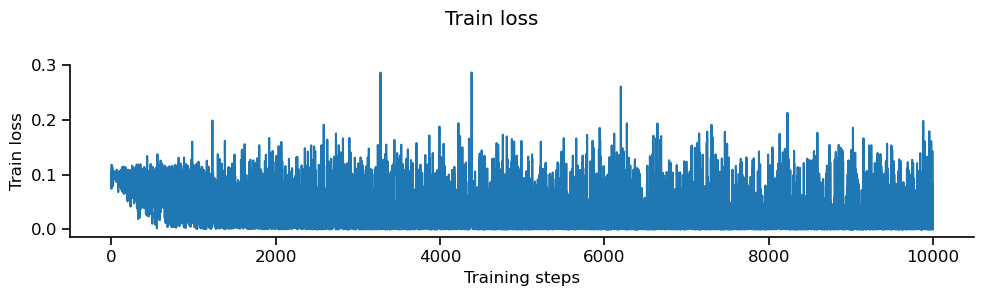

In [53]:
pt.plot_train_loss_history(bp_network)


In [44]:
# Train network
data_generator.manual_seed(data_seed)
bp_network.train(train_sub_dataloader, 
                test_dataloader, 
                epochs=epochs,
                val_interval=(0,-1,1000),
                store_history=True, 
                store_params=False,
                status_bar=True)

ut.compute_batch_accuracy(bp_network, test_dataloader)
pt.plot_train_loss_history(bp_network)

# pt.plot_test_loss_history(bp_network, test_dataloader, stepsize=50)
# pt.plot_MNIST_examples(bp_network, test_dataloader)

TypeError: train() got an unexpected keyword argument 'compile'

### Backprop (Dale's Law)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Batch accuracy = 73.69000244140625%


  0%|          | 0/101 [00:00<?, ?it/s]

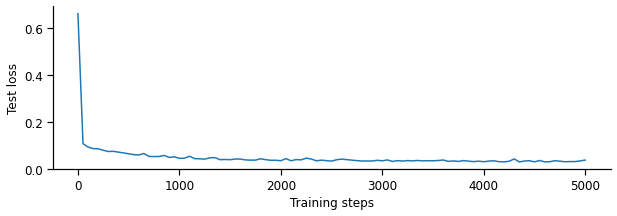

In [6]:
# Create network
network_config = ut.read_from_yaml('EIANN/config/MNIST/EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=network_seed, device=device, **training_kwargs)


# Train network
data_generator.manual_seed(data_seed)
bpDale_network.train(train_sub_dataloader, 
              epochs=epochs, 
              store_history=True,
              store_weights=True,
              status_bar=True)

ut.compute_batch_accuracy(bpDale_network, test_dataloader)
# pt.plot_train_loss_history(bpDale_network)
pt.plot_test_loss_history(bpDale_network, test_dataloader, stepsize=50)
# pt.plot_MNIST_examples(bpDale_network, test_dataloader)

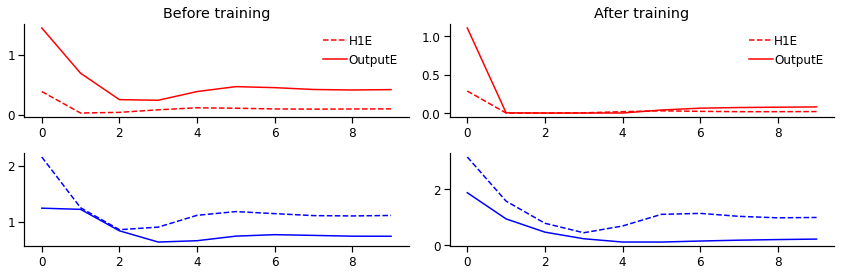

In [11]:
from EIANN.plot import *

fig,ax = plt.subplots(2,2,figsize=(12,4))

t = 0
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,0].plot(hidden_activity.cpu(),'--',color='r', label='H1E')
ax[0,0].plot(output_activity.cpu(),color='r', label='OutputE')
ax[0,0].set_title('Before training')
ax[0,0].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,0].plot(hiddenFBI_activity.cpu(),'--',color='b', label='H1FBI')
ax[1,0].plot(outputFBI_activity.cpu(),color='b', label='OutputFBI')


t = -1
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,1].plot(hidden_activity.cpu(),'--',color='r', label='H1E')
ax[0,1].plot(output_activity.cpu(),color='r', label='OutputE')
ax[0,1].set_title('After training')
ax[0,1].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,1].plot(hiddenFBI_activity.cpu(),'--',color='b', label='H1FBI')
ax[1,1].plot(outputFBI_activity.cpu(),color='b', label='OutputFBI')

plt.tight_layout()
plt.show()

## BTSP

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Batch accuracy = 9.800000190734863%


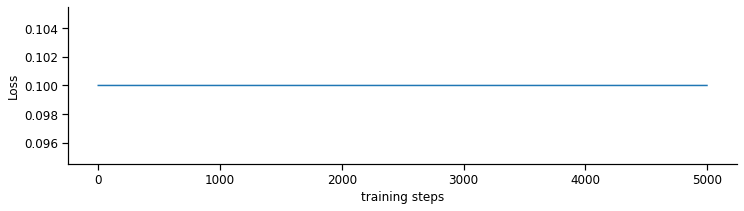

In [6]:
# Create network
network_config = ut.read_from_yaml('EIANN/config/MNIST/EIANN_1_hidden_mnist_BTSP_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, device=device, **training_kwargs)


# Train network
data_generator.manual_seed(data_seed)
btsp_network.train(train_sub_dataloader, 
                   epochs=epochs, 
                   store_history=False, 
                   store_weights=True, 
                   status_bar=True)

ut.compute_batch_accuracy(btsp_network, test_dataloader)
pt.plot_train_loss_history(btsp_network)
# pt.plot_test_loss_history(btsp_network, test_dataloader, stepsize=100)
# pt.plot_MNIST_examples(btsp_network, test_dataloader)